## Binomial example on large 2d lattice

In [126]:
using Pkg; Pkg.activate(".");
using Statistics
using StatsFuns
using Random
using LinearAlgebra
using Distributions
using Colors
using ProgressMeter
using Base.Threads
include("src/AdaptiveRejectionSampling2.jl")
using Plots
default(fmt = :png)
using Images
using TestImages
using FileIO

 Activating environment at `C:\Users\mauri\Github\BayesianGFL\Project.toml`


In [76]:
function binomial_gibbs_step(
    s::Float64,  # successes
    a::Float64,  # attempts
    nbr_values::Vector{Float64} = [0.0],
    ;
    λ_tv1::Vector{Float64} = zeros(length(s)),
    λ_tv2::Vector{Float64} = zeros(length(s)),
    λ_lasso::Float64 = 0.0,
    λ_ridge::Float64 = 0.0,
)::Float64 
    # gibss step from fused elastic net 
    ϵ = 1e-6
    a = a + 2ϵ
    s = s + ϵ
    target(θ) = begin
        logll = if θ >= 0
            logll = - a * log(1.0 + exp(-θ)) - (a - s) * θ
        else
            logll = s * θ - a * log(1.0 + exp(θ))
        end
        tv1 = 0.5 * dot(abs.(θ .- nbr_values), λ_tv1)
        tv2 = 0.5 * dot((θ .- nbr_values).^2, λ_tv2)
        reg = λ_lasso * abs(θ) + λ_ridge * θ^2
        logll - tv1 - tv2 - reg
    end
    support = (-Inf, Inf)
    θc = logit(s / a)
    m, M = minimum(nbr_values), maximum(nbr_values)
    envelope_init = (min(θc,  m) - 1e-2, max(θc, M) + 1e-2)
    sampler = RejectionSampler(
        target, support, envelope_init, max_segments=10, from_log=true
    )
    run_sampler!(sampler, 1)[1]
end 


function binomial_gibbs_sweep(
    θ::Vector{Float64},  # current
    s::Vector{Float64},  # successes
    a::Vector{Float64},  # attempts
    nbrs::Vector{Vector{Int}} # neighbors
    ;
    λ_tv1::Vector{Vector{Float64}} = [zeros(length(x)) for x in nbrs],
    λ_tv2::Vector{Vector{Float64}} = [zeros(length(x)) for x in nbrs],
    λ_lasso::Vector{Float64} = zeros(length(s)),
    λ_ridge::Vector{Float64} = zeros(length(s)),
)
    T = length(θ)
    θnew = zeros(Float64, T)
    @inbounds @threads for t in 1:T
        nbr_values = [θ[i] for i in nbrs[t]]
        θnew[t] = binomial_gibbs_step(
            s[t],
            a[t],
            nbr_values,
            λ_tv1=λ_tv1[t],
            λ_tv2=λ_tv2[t],
            λ_lasso=λ_lasso[t],
            λ_ridge=λ_ridge[t]
        )
    end
    return θnew
end


function binomial_bayesian_gfl(
    s::Vector{Float64},  # successes
    a::Vector{Float64},  # attempts
    nbrs::Vector{Vector{Int}},
    n::Int  # chain iterations (full sweeps),
    ;
    λ_tv1::Vector{Vector{Float64}} = [zeros(length(x)) for x in nbrs],
    λ_tv2::Vector{Vector{Float64}} = [zeros(length(x)) for x in nbrs],
    λ_lasso::Vector{Float64} = zeros(length(s)),
    λ_ridge::Vector{Float64} = zeros(length(s)),
    θ₀::Vector{Float64} = zeros(length(s)),  # initial values
    thinning::Int = 1
)
    T = length(s)
    
    num_samples = n ÷ thinning
    θ = zeros(Float64, T, num_samples + 1)
    
    θ_curr = θ₀    
    num_saved = 0
    @showprogress for i in 1:(num_samples * thinning + 1)
        θ_curr = binomial_gibbs_sweep(
            θ_curr, s, a, nbrs; λ_tv1=λ_tv1, λ_tv2=λ_tv2, λ_lasso=λ_lasso, λ_ridge=λ_ridge
        )
        if i == 1 || i % thinning == 0
            θ[:, num_saved + 1] = θ_curr
            num_saved += 1
        end
    end
    return θ
end

binomial_bayesian_gfl (generic function with 1 method)

Grid size: (768, 1024)


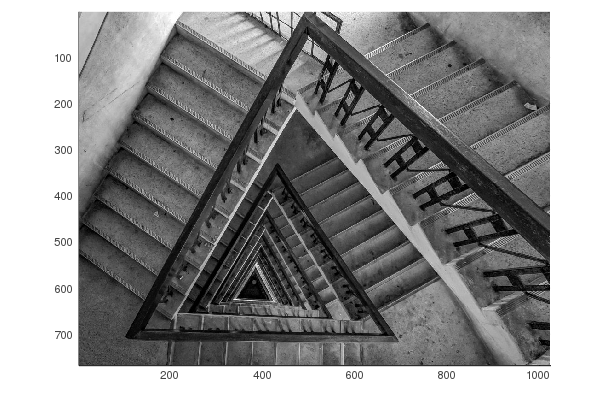

In [129]:
# option 1: random squares
# nr = 1000
# nc = 1000

# Random.seed!(110104)

# grid = zeros(nr, nc)

# vals = Dict((0, 0) => rand())

# for i in 1:nr
#     for j in 1:nc
#         sig = (i ÷ 250, j ÷ 250)
#         !haskey(vals, sig) && (vals[sig] = rand())
#         grid[i, j] = vals[sig]
#     end
# end

# # option 2: mri images
# img = testimage("mri-stack") # 226×186×27 Gray image
# img = img[:, :, 1:20]
# img = mosaicview(img; npad=4, ncol=5, fillvalue=0.75)
# grid = Float64.(0.1 .+ 0.8 .*img)
# nr, nc = size(grid)  # 

# println("Grid size: $(size(grid))")
# plot(Gray.(grid), size=(600, 600))

# option 3: art pattern
img = Gray.(load("./test_1024_768.jpg"))
grid = Float64.(img)
nr, nc = size(grid)  # 

println("Grid size: $(size(grid))")
plot(Gray.(grid), size=(700, 700))

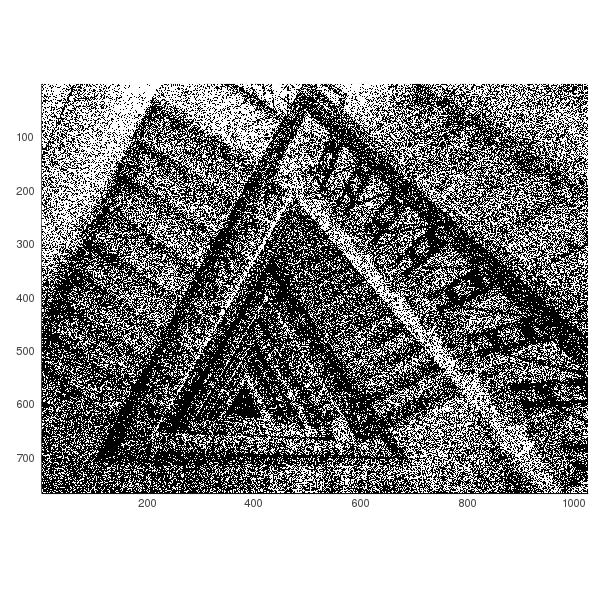

In [133]:
s = zeros(nr, nc)
a = zeros(nr, nc)

for i in 1:nr
    for j in 1:nc
        a[i, j] = 1  # rand(1:5)
        s[i, j] = rand(Binomial(a[i, j], grid[i, j]))
    end
end

plot(Gray.(s ./ a), size=(700, 700))

In [134]:
index_map = reshape(1:(nr * nc), (nr, nc));

In [149]:
# build graph
nbrs = Vector{Int}[]
λ_tv1 = Vector{Float64}[]
λ_tv2 = Vector{Float64}[]
num_edges = 0
for j in 1:nc
    for i in 1:nr
        nbrs_ = Int[]
        (i > 1) && push!(nbrs_, index_map[i - 1, j])
        (i < nr) && push!(nbrs_, index_map[i + 1, j])
        (j > 1) && push!(nbrs_, index_map[i, j - 1])
        (j < nc) && push!(nbrs_, index_map[i, j + 1])
        push!(nbrs, nbrs_)
        push!(λ_tv1, ones(length(nbrs_)))
        push!(λ_tv2, 0.0 * ones(length(nbrs_)))
        num_edges += length(nbrs_)
    end
end

num_edges = num_edges ÷ 2
s_vec = vec(s);
a_vec = vec(a);

In [150]:
print("Num edges: $num_edges, Num nodes: $(nc * nr)")

Num edges: 1571072, Num nodes: 786432

In [163]:
N = 1_500
thinning = 2
λ = 5.0
chain = binomial_bvayesian_gfl(
    s_vec, a_vec, nbrs, N, λ_tv1=λ .* λ_tv1, λ_tv2=λ_tv2, thinning=thinning
);

Progress: 100%|█████████████████████████████████████████| Time: 1:38:18


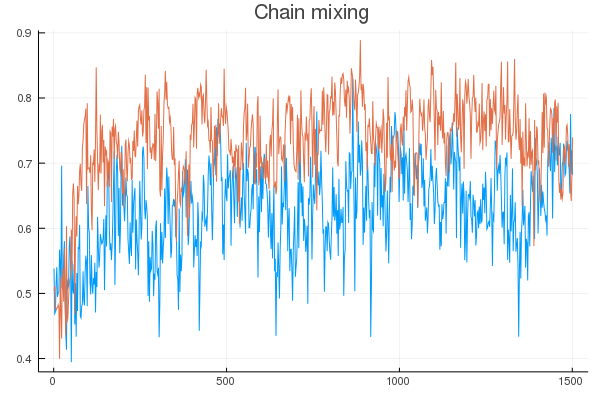

In [170]:
x = [(i - 1) * thinning + 1 for i in 1:size(chain, 2)]
plot(x, logistic.(chain[[100000, 10000], :]'), lab="", title="Chain mixing")

In [ ]:
burnin = size(chain, 2) ÷ 2
m = median(logistic.(chain[:, burnin + 1:end]), dims=2)
m = reshape(vec(m), (nr, nc));
iqrv = [iqr(logistic.(chain[i, burnin + 1:end])) for i in 1:(nr * nc)]
iqrv = (iqrv .- minimum(iqrv)) ./ (maximum(iqrv) - minimum(iqrv))
iqrv = reshape(iqrv, (nr, nc));

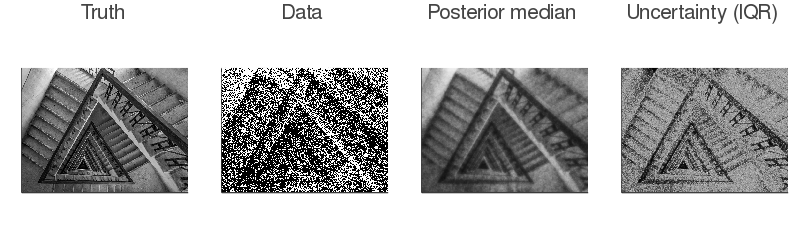

In [173]:
p3 = plot(Gray.(m), title="Posterior median")
p1 = plot(Gray.(grid), title="Truth")
p2 = plot(Gray.(s ./ a), title="Data")
p = plot(Gray.(iqrv), title="Uncertainty (IQR)")
plot(p1, p2, p3, p4, layout=(1, 4), size=(800, 250), axis=nothing)

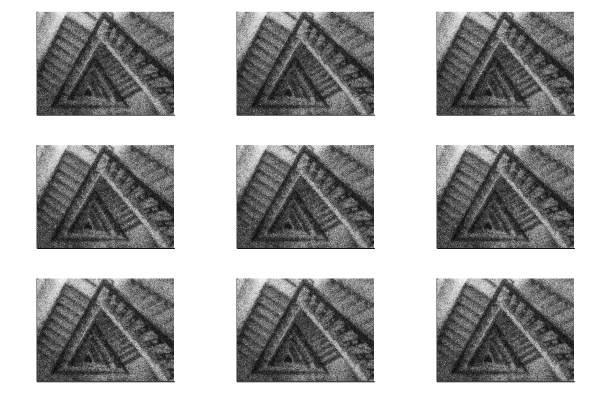

In [172]:
skip = 1
plts = 9
idxs = [N ÷ thinning - (i - 1) * skip for i in 1:plts]

plots = []
for i in 1:plts
    x = reshape(logistic.(chain[:, idxs[i]]), (nr, nc))
    p = plot(Gray.(x))
    push!(plots, p)
end
plot(plots..., axis=nothing)